Let's load up our data and do a little feature engineering to make everything numeric. We have some missing data, and without knowing anything more we're going to just fill those values with zeros.

In [1]:
import pandas as pd

COLUMNS = ['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance', 'Going_outside', 'Drained_after_socializing', 'Friends_circle_size', 'Post_frequency', ]
DATA = '/kaggle/input/extrovert-vs-introvert-behavior-data/personality_dataset.csv'
TARGET = 'Personality'
df = pd.read_csv(filepath_or_buffer=DATA)
df['Stage_fear'] = df['Stage_fear'] == 'Yes'
df['Drained_after_socializing'] = df['Drained_after_socializing'] == 'Yes'
df[TARGET] = df[TARGET] == 'Extrovert'
df = df.fillna(value=0)
df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,False,4.0,6.0,False,13.0,5.0,True
1,9.0,True,0.0,0.0,True,0.0,3.0,False
2,9.0,True,1.0,2.0,True,5.0,2.0,False
3,0.0,False,6.0,7.0,False,14.0,8.0,True
4,3.0,False,9.0,4.0,False,8.0,5.0,True


Are our classes balanced?

In [2]:
df['Personality'].value_counts(normalize=True).to_frame().T

Personality,True,False
proportion,0.514138,0.485862


They are nearly balanced. Next let's use dimensionality reduction and see what our data looks like.

In [3]:
from sklearn.manifold import TSNE

reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
df[['x', 'y']] = reducer.fit_transform(X=df[COLUMNS])

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 2900 samples in 0.004s...
[t-SNE] Computed neighbors for 2900 samples in 0.087s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2900
[t-SNE] Computed conditional probabilities for sample 2000 / 2900
[t-SNE] Computed conditional probabilities for sample 2900 / 2900
[t-SNE] Mean sigma: 0.891079
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.559692
[t-SNE] KL divergence after 1000 iterations: 1.344671


<Axes: xlabel='x', ylabel='y'>

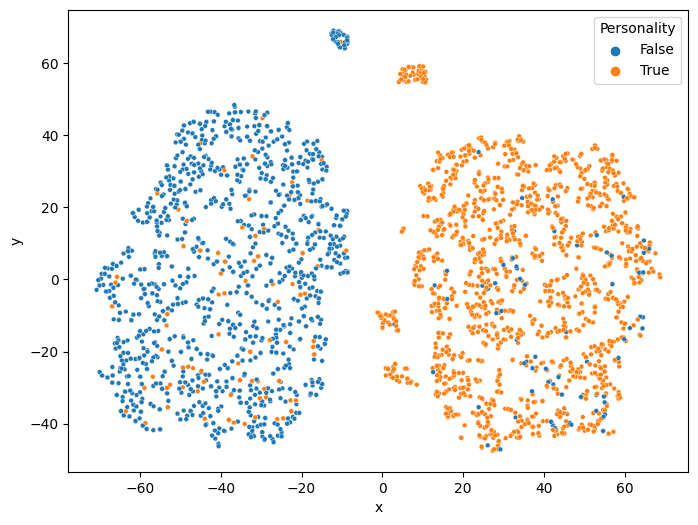

In [4]:
from seaborn import scatterplot
import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(8, 6))
scatterplot(data=df, x='x', y='y', hue=TARGET, ax=ax, s=12)

Our plot suggests we should be able to build a pretty good model without a lot of work. But we also probably have some introverts who think they are extroverts and vice versa. Let's build a model.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[COLUMNS], df[TARGET], test_size=0.25, random_state=2024, stratify=df[TARGET])
logreg = LogisticRegression(max_iter=100, tol=1e-12).fit(X_train, y_train)
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=logreg.predict(X=X_test))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_test, y_pred=logreg.predict(X=X_test))))
print(classification_report(y_true=y_test, y_pred=logreg.predict(X=X_test)))

model fit in 46 iterations
accuracy: 0.9117
f1: 0.9117
              precision    recall  f1-score   support

       False       0.90      0.92      0.91       352
        True       0.92      0.91      0.91       373

    accuracy                           0.91       725
   macro avg       0.91      0.91      0.91       725
weighted avg       0.91      0.91      0.91       725



An f1 of 0.91 isn't bad for almost no effort. What do our model probabilities look like?

<Axes: xlabel='probability', ylabel='Count'>

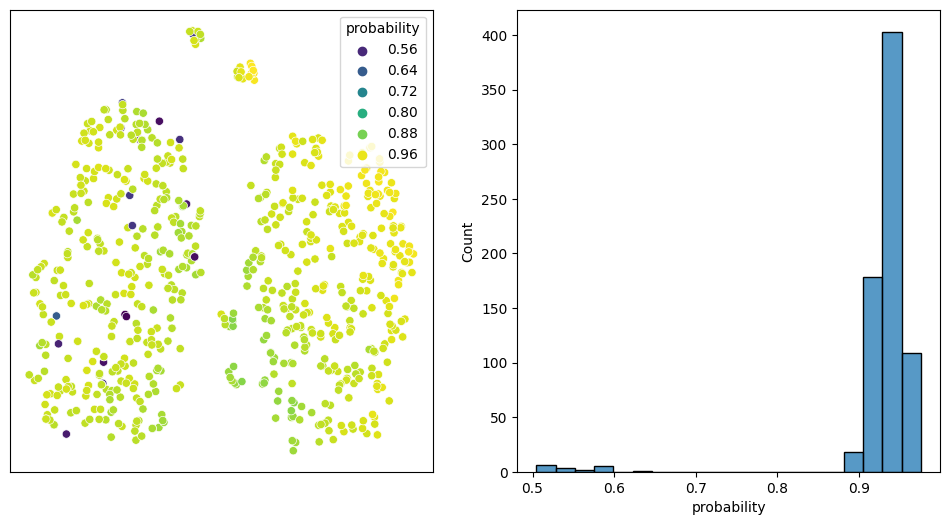

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from seaborn import histplot
from seaborn import scatterplot

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')


plot_df = df.iloc[X_test.index][['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=X_test), axis=1)

plt, ax = plt.subplots(ncols=2, figsize=(12, 6))
scatterplot(ax=ax[0], data=plot_df, x='x', y='y', hue='probability', palette='viridis')
ax[0].set(xlabel=None) 
ax[0].set(ylabel=None)
ax[0].set(xticklabels=[])
ax[0].set(yticklabels=[])
ax[0].tick_params(axis='both', which='both', length=0)
histplot(ax=ax[1], data=plot_df, x='probability', bins=20)

Our model probabilities are essentially bimodel: we have one mode where our model probabilities are greater than about 0.85, and another where they are less than 0.7. It is kind of interesting to see that in our scatter plot, the model probabilities are generally lower toward the gap between our two clusters. And then our very low probabilities (remember: because we only have two classes, our model probabilities can never be less than 0.5) are scattered across our False cluster. These are probably cases our model mis-predicted.